# 2021-10-09 Getting ready for deterministic fits of non-affordance-based value functions

Results below are for commit: https://github.com/gmarkkula/COMMOTIONSFramework/commit/36a0381d1a2713bc510f85cf1575e78b55ebdb52 (Rerunning the code below for other commits is not guaranteed/likely to give the same results.)

Getting stuff into shape for fitting non-`oVA` models.

I have:
* Fixed `sc_scenario_helper.get_time_to_sc_agent_collision()`, which isn't used by the `oVA` models, and which I therefore had overlooked as I was making the needed changes elsewhere to permit `oVAa`. While doing this, and updating the TTC-related unit tests in that module, I also made minor tweaks to functions `get_time_to_dist_with_acc()` and `get_entry_exit_times()` - which shouldn't really make a difference to anything except the `get_time_to_agent_collision()` function.
    * Just to make sure this was the case, I reran do_1...py and do_2...py for the same parameter grid as in 2021-10-06b (second batch of deterministic fits), and verified that I indeed got exactly the same max number of criteria met for each model, for the same number of parameterisations. (Not saving the results of these runs.)
* Tweaked the default non-affordance-based value function gains in `sc_scenario.py` to be more analogous to the affordance-based ones.

Below I am trying to figure out what parameter ranges I should be searching for these models.

In [1]:
# add the root folder of this repository to the Python path
import os
import sys
THIS_DIR = os.path.abspath('.')
PARENT_DIR, __ = os.path.split(THIS_DIR)
if not PARENT_DIR in sys.path:
    sys.path.append(PARENT_DIR)

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
from sc_scenario import get_default_params, get_assumptions_dict, SCSimulation
from sc_scenario_helper import CtrlType

## Trying a basic startup scenario

I have tweaked the default $k_{da}$ parameter for the car (the pedestrian doesn't have one - or more specifically even adding one wouldn't make any difference because there is never any acceleration for the pedestrian in its predicted state), to $k_{da} = 0.01$, which gives a pretty similar startup behaviour to that seen for the affordance-based car agent (see for example 2021-09-16b):

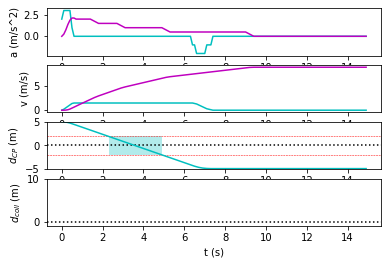

In [33]:
NAMES = ('P', 'V')
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-500, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = False, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True)

## Looking for reasonable values of $k_c$ and $k_{sc}$

In Yi-Shin's paper, reasonable values for $k_c$ and $k_{sc}$ seem to be about 0.5-1, but that was for $k_g = 1$ for both agents. Here were are now balancing $k_g$s to achieve the same free-speed value $V_{free} = 1$ for both agents, which means $k_g = 1.333$ for the pedestrian and $k_g = 0.2$ for the car. Therefore I would expect sensible behaviour with the pedestrian's $k_c$ in a range about 0.7-1.333 and the car's $k_{sc}$ in a range 0.1-0.2. 

### Pedestrian
Below some one-sided simulations, where we can see that for the pedestrian that I got the lower edge pretty correct - the model becomes collision free at $k_c = 0.8$. There is also a shift between passing before and after the car with a 0.3 s pedestrian lead, with $k_c = 1$ and above, but it's not really the case that the model behaves insensibly at higher values.

*** k_c = 0.20
	Pedestrian lead 0 s:


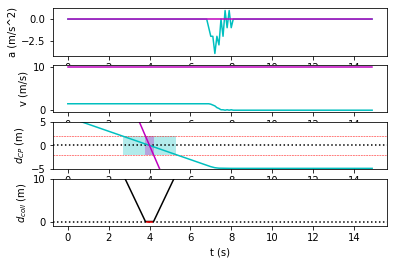

	Pedestrian lead 0.3 s:


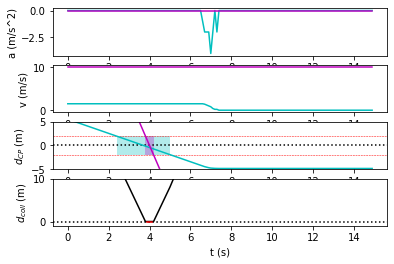

*** k_c = 0.30
	Pedestrian lead 0 s:


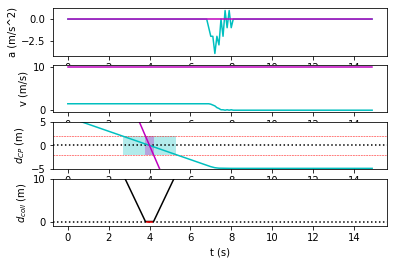

	Pedestrian lead 0.3 s:


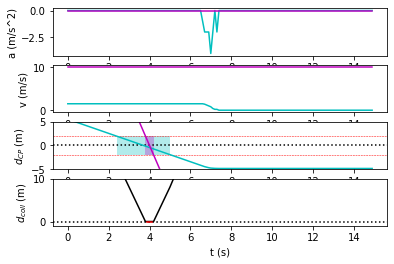

*** k_c = 0.40
	Pedestrian lead 0 s:


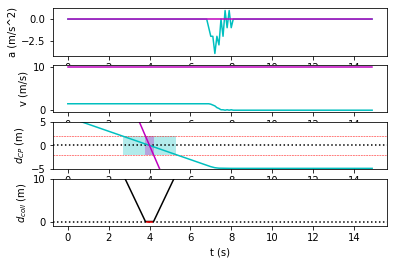

	Pedestrian lead 0.3 s:


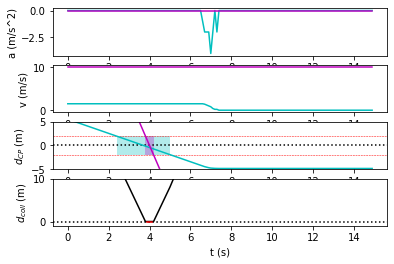

*** k_c = 0.50
	Pedestrian lead 0 s:


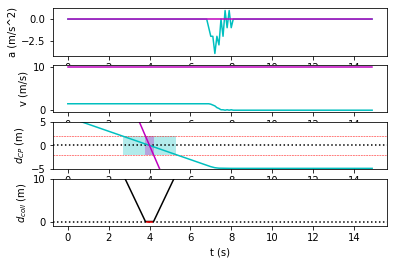

	Pedestrian lead 0.3 s:


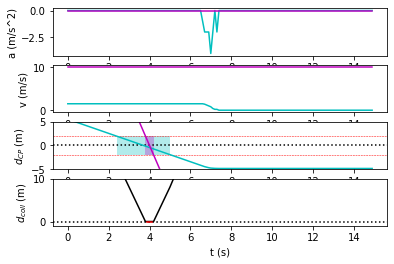

*** k_c = 0.60
	Pedestrian lead 0 s:


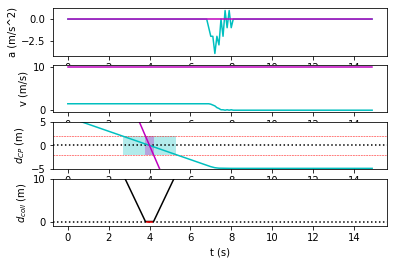

	Pedestrian lead 0.3 s:


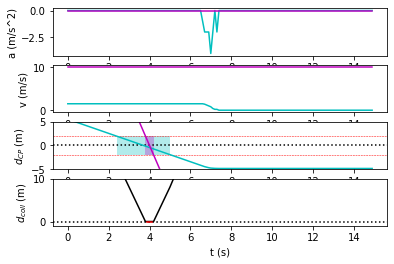

*** k_c = 0.70
	Pedestrian lead 0 s:


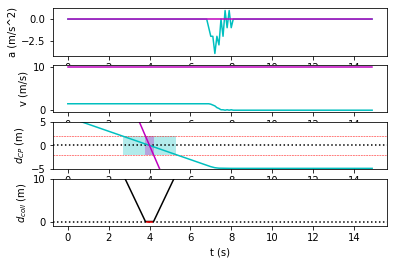

	Pedestrian lead 0.3 s:


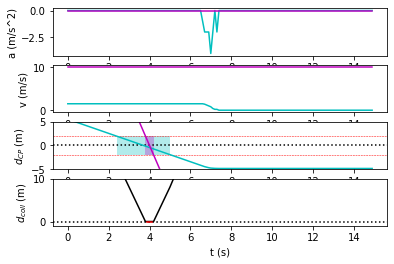

*** k_c = 0.80
	Pedestrian lead 0 s:


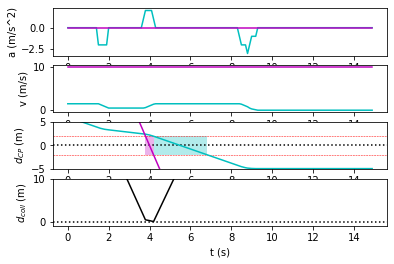

	Pedestrian lead 0.3 s:


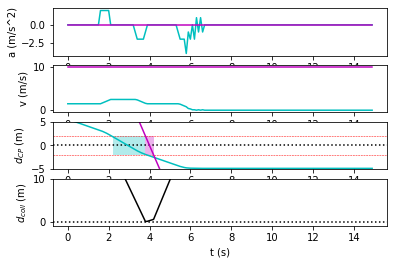

*** k_c = 0.90
	Pedestrian lead 0 s:


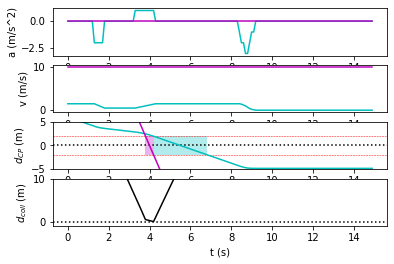

	Pedestrian lead 0.3 s:


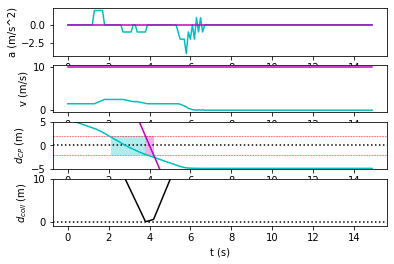

*** k_c = 1.00
	Pedestrian lead 0 s:


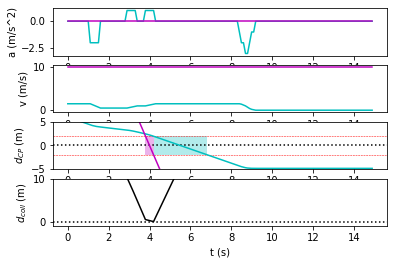

	Pedestrian lead 0.3 s:


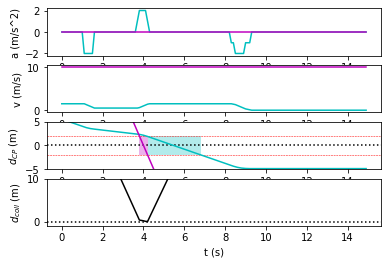

*** k_c = 1.10
	Pedestrian lead 0 s:


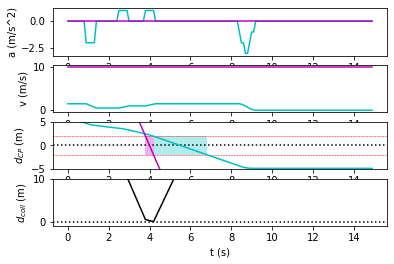

	Pedestrian lead 0.3 s:


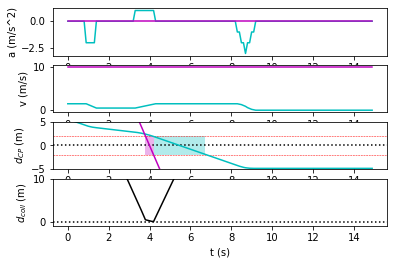

*** k_c = 1.20
	Pedestrian lead 0 s:


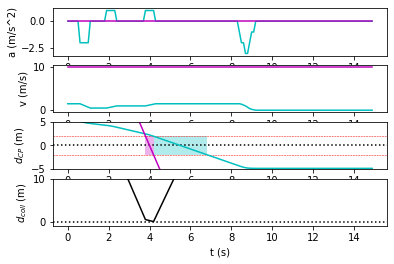

	Pedestrian lead 0.3 s:


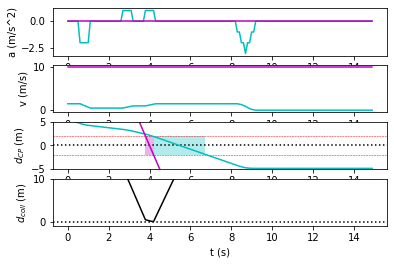

*** k_c = 1.30
	Pedestrian lead 0 s:


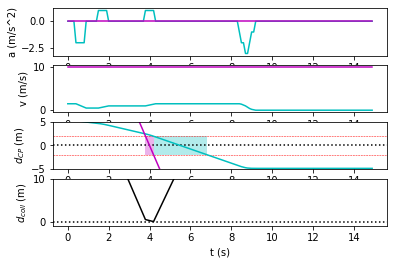

	Pedestrian lead 0.3 s:


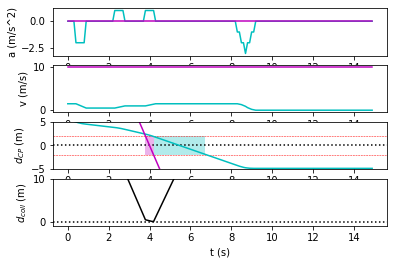

*** k_c = 1.40
	Pedestrian lead 0 s:


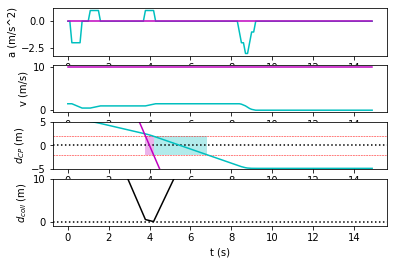

	Pedestrian lead 0.3 s:


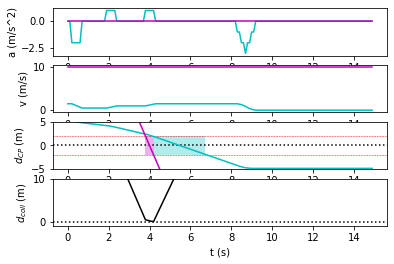

In [38]:
__, params_k = get_default_params(oVA=False)
INITIAL_SPEEDS = np.array((sc_scenario.FREE_SPEED_SPEED_CTRL,
                           sc_scenario.FREE_SPEED_ACC_CTRL))
BASE_TTCP = 4
TTCP_MARGIN = 0.3
CONST_ACCS = (None, 0)

for k_c in np.arange(0.2, 1.5, 0.1):
    print(f'*** k_c = {k_c:.2f}')
    params_k[CtrlType.SPEED]._c = k_c
    for ped_lead in (0, TTCP_MARGIN):
        print(f'\tPedestrian lead {ped_lead} s:')
        ped_ttcp = BASE_TTCP - ped_lead
        ttcps = np.array((ped_ttcp, BASE_TTCP))
        initial_dists = INITIAL_SPEEDS * ttcps
        initial_positions = np.array(((0, -initial_dists[0]), (initial_dists[1], 0)))
        #print(initial_positions)
        sc_simulation = SCSimulation(
                CTRL_TYPES, GOALS, initial_positions, initial_speeds = INITIAL_SPEEDS, 
                end_time = 15, optional_assumptions = optional_assumptions,
                agent_names = NAMES, params_k = params_k, const_accs = CONST_ACCS)
        sc_simulation.run()
        sc_simulation.do_plots(kinem_states = True)

### Vehicle

For the vehicle it's even harder to find the switch where it accelerates to resolve the situation in these one-sided simulations. But again I sort of confirm my guess for the lower edge of $k_{sc}$ - the model becomes collision free in these simulations at $k_{sc} = 0.07$.

*** k_sc = 0.01
	Vehicle lead 0 s:


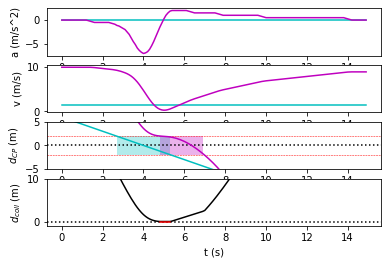

	Vehicle lead 1.4 s:


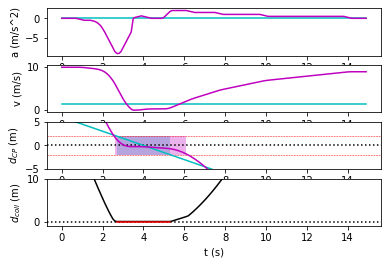

	Vehicle lead 1.5 s:


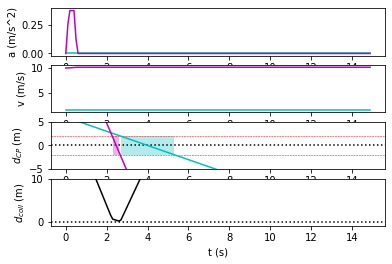

*** k_sc = 0.02
	Vehicle lead 0 s:


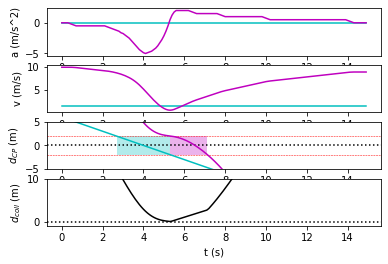

	Vehicle lead 1.4 s:


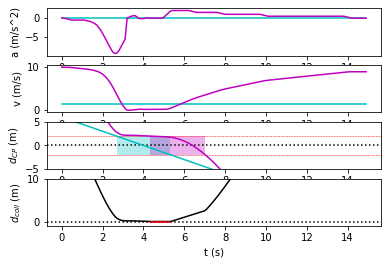

	Vehicle lead 1.5 s:


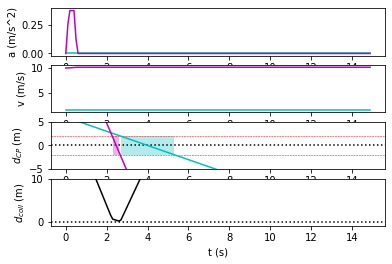

*** k_sc = 0.03
	Vehicle lead 0 s:


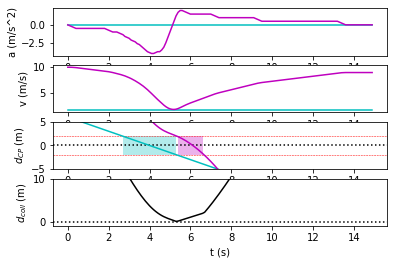

	Vehicle lead 1.4 s:


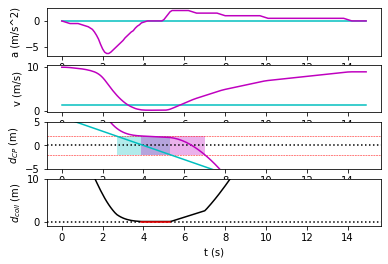

	Vehicle lead 1.5 s:


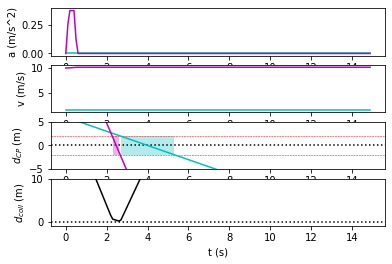

*** k_sc = 0.04
	Vehicle lead 0 s:


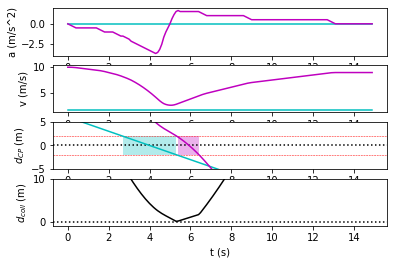

	Vehicle lead 1.4 s:


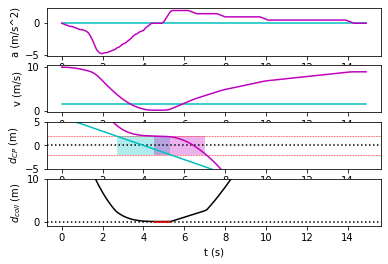

	Vehicle lead 1.5 s:


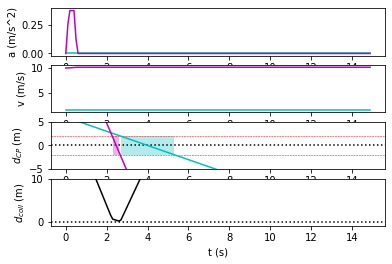

*** k_sc = 0.05
	Vehicle lead 0 s:


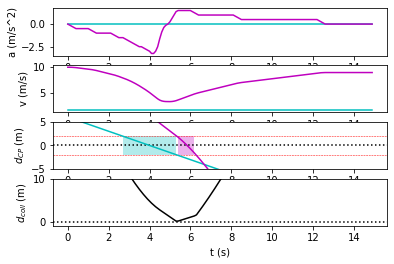

	Vehicle lead 1.4 s:


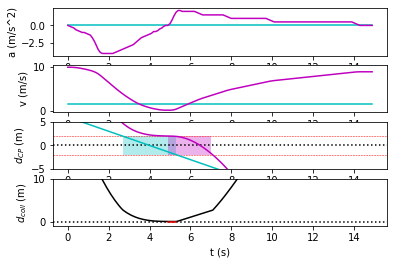

	Vehicle lead 1.5 s:


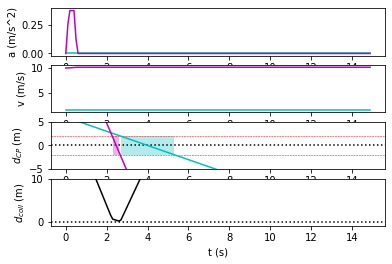

*** k_sc = 0.06
	Vehicle lead 0 s:


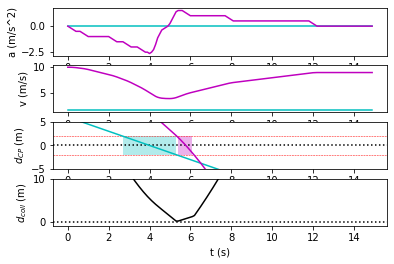

	Vehicle lead 1.4 s:


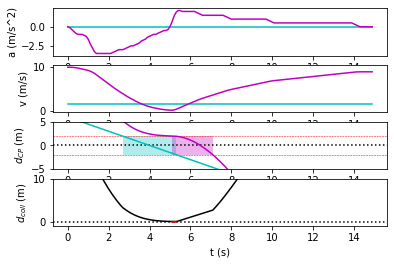

	Vehicle lead 1.5 s:


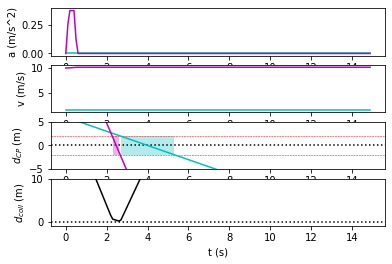

*** k_sc = 0.07
	Vehicle lead 0 s:


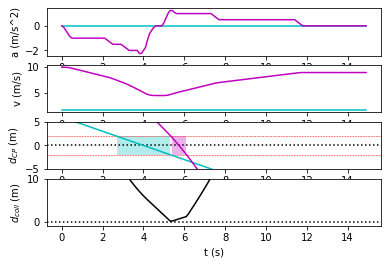

	Vehicle lead 1.4 s:


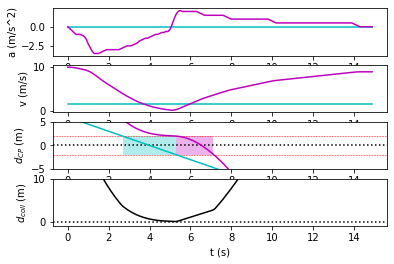

	Vehicle lead 1.5 s:


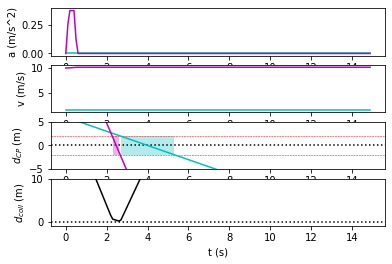

*** k_sc = 0.08
	Vehicle lead 0 s:


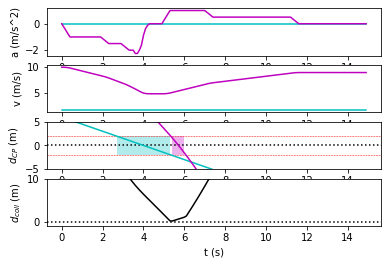

	Vehicle lead 1.4 s:


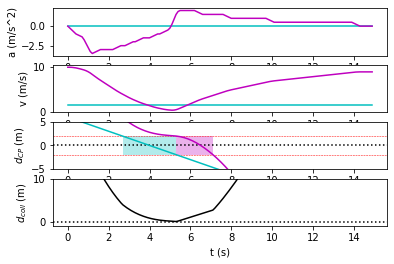

	Vehicle lead 1.5 s:


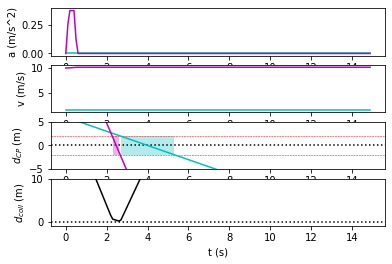

*** k_sc = 0.09
	Vehicle lead 0 s:


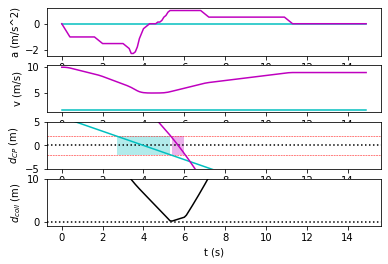

	Vehicle lead 1.4 s:


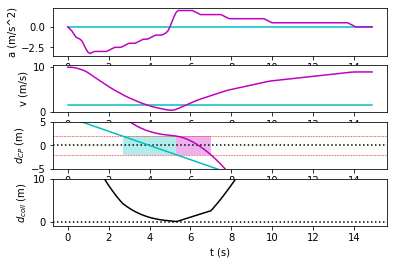

	Vehicle lead 1.5 s:


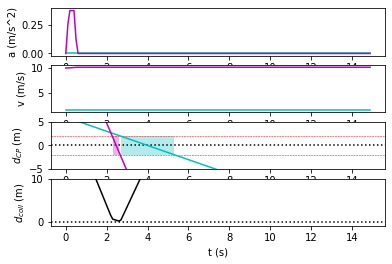

In [37]:
__, params_k = get_default_params(oVA=False)
BASE_TTCP = 4
CONST_ACCS = (0, None)

for k_sc in np.arange(0.01, 0.1, 0.01):
    print(f'*** k_sc = {k_sc:.2f}')
    params_k[CtrlType.ACCELERATION]._sc = k_sc
    for veh_lead in (0, 1.4, 1.5):
        print(f'\tVehicle lead {veh_lead} s:')
        veh_ttcp = BASE_TTCP - veh_lead
        ttcps = np.array((BASE_TTCP, veh_ttcp))
        initial_dists = INITIAL_SPEEDS * ttcps
        initial_positions = np.array(((0, -initial_dists[0]), (initial_dists[1], 0)))
        #print(initial_positions)
        sc_simulation = SCSimulation(
                CTRL_TYPES, GOALS, initial_positions, initial_speeds = INITIAL_SPEEDS, 
                end_time = 15, optional_assumptions = optional_assumptions,
                agent_names = NAMES, params_k = params_k, const_accs = CONST_ACCS)
        sc_simulation.run()
        sc_simulation.do_plots(kinem_states = True)

## Conclusion

Overall I am thinking that I could opt for ranges starting from half of the lower edges identified above, up to three times those lower edges. So something like:
* $k_c \in [0.4, 2.4]$
* $k_{sc} \in [0.035, 0.21]$

Or cleaned up:
* $k_c \in [0.2, 2]$
* $k_{sc} \in [0.02, 0.2]$

Probably best with logarithmic spacing.

And I'll leave it at $k_{da} = 0.01$ based on the argument further above.
